In [1]:
#NOTE: use python env acmil in ACMIL folder
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo, get_performance
from train_utils import pull_tiles, FocalLoss
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction_sepatt, BCE_Weighted_Reg, BCE_Weighted_Reg_focal, compute_loss_for_all_labels_sepatt
from Model import Mutation_MIL_MT_sepAtt #, Mutation_MIL_MT
from ACMIL import ACMIL_GA_MultiTask, predict, train_one_epoch_multitask, evaluate_multitask
warnings.filterwarnings("ignore")
%matplotlib inline


#FOR ACMIL
current_dir = os.getcwd()
grandparent_subfolder = os.path.join(current_dir, '..', '..', 'other_model_code','ACMIL-main')
grandparent_subfolder = os.path.normpath(grandparent_subfolder)
sys.path.insert(0, grandparent_subfolder)
from utils.utils import save_model, Struct, set_seed
import yaml
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import yaml
from pprint import pprint

import argparse
import torch
from torch.utils.data import DataLoader

from utils.utils import save_model, Struct, set_seed
from datasets.datasets import build_HDF5_feat_dataset
from architecture.transformer import ACMIL_GA #ACMIL_GA
from architecture.transformer import ACMIL_MHA
import torch.nn.functional as F
import wandb

In [2]:
####################################
######      USERINPUT       ########
####################################
ALL_LABELS = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
TUMOR_FRAC_THRES = 0.9 
feature_extraction_method = 'uni2' #retccl, uni1
learning_method = "acmil"
focal_gamma = 20
focal_alpha = 0.95
loss_method = 'Focal' #ATTLOSS
agg_method = 'sum'

################################
#model Para
BATCH_SIZE  = 1
DROPOUT = 0
DIM_OUT = 128
SELECTED_MUTATION = "MT"
SELECTED_FOLD = 3
arch = 'ga_mt' #ga_mt or ga

if feature_extraction_method == 'retccl':
    SELECTED_FEATURE = [str(i) for i in range(0,2048)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 2048
elif feature_extraction_method == 'uni1': 
    SELECTED_FEATURE = [str(i) for i in range(0,1024)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 1024
elif feature_extraction_method == 'uni2':
    SELECTED_FEATURE = [str(i) for i in range(0,1536)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 1536
    
################################
# get config
config_dir = "myconf.yml"
with open(config_dir, "r") as ymlfile:
    c = yaml.load(ymlfile, Loader=yaml.FullLoader)
    #c.update(vars(args))
    conf = Struct(**c)

conf.train_epoch = 100
conf.D_feat = N_FEATURE
conf.n_class = 1
conf.n_task = 7
#conf.lr = 0.000001 #change this for HR only

# Print all key-value pairs in the conf object
for key, value in conf.__dict__.items():
    print(f"{key}: {value}")
    
##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
folder_name_overlap = "IMSIZE250_OL100"
folder_name_nonoverlap = "IMSIZE250_OL0"
feature_path_opx_train =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_overlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_opx_test =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_tma = os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "TAN_TMA_Cores",folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_tcga = os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "TCGA_PRAD",folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))

folder_name_ids = 'uni1/TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES)  + "/"
train_val_test_id_path =  os.path.join(proj_dir + 'intermediate_data/6_Train_TEST_IDS', folder_name_ids)

train_epoch: 100
warmup_epoch: 0
wd: 1e-05
lr: 0.0001
min_lr: 0
dataset: bracs
B: 1
n_class: 1
n_worker: 8
pin_memory: False
n_shot: -1
D_feat: 1536
n_task: 7


In [3]:
######################
#Create output-dir
################################################
folder_name1 = feature_extraction_method + '/TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES)  + "/"
outdir0 =  proj_dir + "intermediate_data/pred_out02282025_othermethods" + "/" + folder_name1 + 'FOLD' + str(SELECTED_FOLD) + '/' + SELECTED_MUTATION + "/" + agg_method + '/'
outdir1 =  outdir0  + "/saved_model/"
outdir2 =  outdir0  + "/model_para/"
outdir3 =  outdir0  + "/logs/"
outdir4 =  outdir0  + "/predictions/"
outdir5 =  outdir0  + "/perf/"


create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)
create_dir_if_not_exists(outdir5)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025_othermethods/uni2/TrainOL100_TestOL0_TFT0.9/FOLD3/MT/sum/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025_othermethods/uni2/TrainOL100_TestOL0_TFT0.9/FOLD3/MT/sum//saved_model/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025_othermethods/uni2/TrainOL100_TestOL0_TFT0.9/FOLD3/MT/sum//model_para/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025_othermethods/uni2/TrainOL100_TestOL0_TFT0.9/FOLD3/MT/sum//logs/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025_othermethods/uni2/TrainOL100_TestOL0_TFT0.9/FOLD3/MT/sum//predictions/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025_othermethods/uni2/Train

In [4]:
################################################
#     Model ready data 
################################################
opx_data_ol100 = torch.load(feature_path_opx_train + '/OPX_data.pth')
opx_ids_ol100 = torch.load(feature_path_opx_train + '/OPX_ids.pth')
opx_info_ol100  = torch.load(feature_path_opx_train + '/OPX_info.pth')

opx_data_ol0 = torch.load(feature_path_opx_test + '/OPX_data.pth')
opx_ids_ol0 = torch.load(feature_path_opx_test + '/OPX_ids.pth')
opx_info_ol0  = torch.load(feature_path_opx_test + '/OPX_info.pth')

tma_data = torch.load(feature_path_tma + '/tma_data.pth')
tma_ids = torch.load(feature_path_tma + '/tma_ids.pth')
tma_info  = torch.load(feature_path_tma + '/tma_info.pth')


tcga_data = torch.load(feature_path_tcga + '/TCGA_data.pth')
tcga_ids = torch.load(feature_path_tcga + '/TCGA_ids.pth')
tcga_info  = torch.load(feature_path_tcga + '/TCGA_info.pth')

In [5]:
########################################################
#Update tma
########################################################
haslabel_indexes = []
for i in range(len(tma_data)):
    if torch.isnan(tma_data[i][1]).all() == False:
        #print(f"Item {i} has the second element all NaNs.")
        haslabel_indexes.append(i)


tma_data = Subset(tma_data, haslabel_indexes)
tma_ids = list(Subset(tma_ids, haslabel_indexes))
tma_info = list(Subset(tma_info, haslabel_indexes))
len(tma_info) #355 if TF0.9, a lot of cores does not have enough cancer tiles > 0.9

355

In [6]:
################################################
#Get train, test IDs
#NOTE: this was in the old train: ['OPX_207','OPX_209','OPX_213','OPX_214','OPX_215']
################################################
train_test_val_id_df = pd.read_csv(train_val_test_id_path + "train_test_split.csv")
train_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TRAIN', 'SAMPLE_ID'])
test_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TEST', 'SAMPLE_ID'])
val_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'VALID', 'SAMPLE_ID'])

In [7]:
################################################
#Get Train, test, val data
################################################
#Train:
inc_idx = [opx_ids_ol100.index(x) for x in train_ids_all]
train_data = Subset(opx_data_ol100, inc_idx)
train_ids =  list(Subset(opx_ids_ol100, inc_idx))
train_info = list(Subset(opx_info_ol100, inc_idx))

#Val:
inc_idx = [opx_ids_ol100.index(x) for x in val_ids_all]
val_data = Subset(opx_data_ol100, inc_idx)
val_ids =  list(Subset(opx_ids_ol100, inc_idx))
val_info = list(Subset(opx_info_ol100, inc_idx))

#Test:
inc_idx = [opx_ids_ol0.index(x) for x in test_ids_all]
test_data = Subset(opx_data_ol0, inc_idx)
test_ids =  list(Subset(opx_ids_ol0, inc_idx))
test_info = list(Subset(opx_info_ol0, inc_idx))

In [8]:
#count labels in train
train_label_counts = [dt[1] for dt in train_data]
train_label_counts = torch.concat(train_label_counts)
count_ones = (train_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/train_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

#count labels in test
test_label_counts = [dt[1] for dt in test_data]
test_label_counts = torch.concat(test_label_counts)
count_ones = (test_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/test_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

#count labels in tma
tma_label_counts = [dt[1] for dt in tma_data] 
tma_label_counts = torch.concat(tma_label_counts)
count_ones = (tma_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/tma_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers) #["AR","PTEN","RB1","TP53"


#count labels in tcga
tcga_label_counts = [dt[1] for dt in tcga_data] 
tcga_label_counts = torch.concat(tcga_label_counts)
count_ones = (tcga_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/tcga_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers) #["AR","PTEN","RB1","TP53"

tensor([11, 25, 30, 20, 58, 11, 10])
['7.2', '16.4', '19.7', '13.2', '38.2', '7.2', '6.6']
tensor([ 7,  7, 10,  2, 14,  7,  7])
['16.3', '16.3', '23.3', '4.7', '32.6', '16.3', '16.3']
tensor([216,   0, 119, 107, 178,   0,   0])
['60.8', '0.0', '33.5', '30.1', '50.1', '0.0', '0.0']
tensor([ 2, 34, 13,  3, 53,  0,  4])
['0.4', '7.6', '2.9', '0.7', '11.9', '0.0', '0.9']


In [9]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(tma_data))
print(len(tcga_data))

152
8
43
355
447


In [10]:
from torch.utils.data import Dataset
class Modified_ModelReadyData(Dataset):
    def __init__(self, original_dataset, agg_method):
        self.original_dataset = original_dataset
        self.agg_method = agg_method

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        embeds, labels, tf_info = self.original_dataset[idx]

        if agg_method == 'mean':
            embeds = embeds.mean(dim=0)  # Shape changes from [13, 1536] -> [1536]
        elif agg_method == 'max':
            embeds, indices = embeds.max(dim=0)  # Shape changes from [13, 1536] -> [1536]
        elif agg_method == 'sum':
            embeds = embeds.sum(dim=0)  # Shape changes from [13, 1536] -> [1536]
        
        return embeds, labels

In [11]:
train_data = Modified_ModelReadyData(train_data, agg_method)
test_data  = Modified_ModelReadyData(test_data,agg_method)
val_data   = Modified_ModelReadyData(val_data,agg_method)
tma_data   = Modified_ModelReadyData(tma_data,agg_method)
tcga_data  = Modified_ModelReadyData(tcga_data,agg_method)

In [12]:
class Simple_classifier(nn.Module):
    def __init__(self, in_features = 2048, act_func = 'tanh', drop_out = 0, n_outcomes = 7, dim_out = 128):
        super().__init__()
        self.in_features = in_features  
        self.L = in_features # 2048 node fully connected layer
        self.n_outs = n_outcomes # number of outcomes
        self.d_out = dim_out   # dim of output layers
        self.drop_out = drop_out

        if act_func == 'leakyrelu':
            self.act_func = nn.LeakyReLU()
        if act_func == 'tanh':
            self.act_func = nn.Tanh()
        elif act_func == 'relu':
            self.act_func = nn.ReLU()

        self.embedding_layer = nn.Sequential(
            nn.Linear(self.in_features, 1024), #linear layer
            self.act_func,
            nn.Linear(1024, 512), #linear layer
            self.act_func,
            nn.Linear(512, 256), #linear layer
            self.act_func,
            nn.Linear(256, dim_out), #linear layer
        )

        #Outcome layers
        self.hidden_layers =  nn.ModuleList([nn.Linear(self.d_out, 1) for _ in range(self.n_outs)])        
        
        self.dropout = nn.Dropout(p=drop_out)

    def forward(self, x):
        r'''
        x size: [1,N_FEATURE]
        '''
        #Linear
        x = self.embedding_layer(x) 

        out = []
        for i in range(len(self.hidden_layers)):
            cur_out = self.hidden_layers[i](x)
            out.append(cur_out)

        #Drop out
        if self.drop_out > 0:
            for i in range(len(self.hidden_layers)):
                out[i] = self.dropout(out[i])
        
        return out

In [13]:
####################################################
#            Train 
####################################################
set_seed(0)
BATCH_SIZE = 32
#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
tma_loader = DataLoader(dataset=tma_data, batch_size=BATCH_SIZE, shuffle=False)
tcga_loader = DataLoader(dataset=tcga_data, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# define network
model = Simple_classifier(in_features = conf.D_feat)
model.to(device)
            
# Example usage:
criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction='mean')

# define optimizer, lr not important at this point
optimizer0 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=conf.wd)
optimizer0 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


In [15]:
ckpt_dir = outdir1 + SELECTED_MUTATION + "/"
create_dir_if_not_exists(ckpt_dir)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025_othermethods/uni2/TrainOL100_TestOL0_TFT0.9/FOLD3/MT/sum//saved_model/MT/' already exists.


In [16]:
from timm.utils import accuracy
from utils.utils import MetricLogger, SmoothedValue, adjust_learning_rate
import torchmetrics

def train_one_epoch_simple_classifer(model, criterion, data_loader, optimizer0, device, epoch, conf):
    """
    Trains the given network for one epoch according to given criterions (loss functions)
    """

    # Set the network to training mode
    model.train()

    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 100

    for data_it, data in enumerate(data_loader):
        image_patches = data[0].to(device, dtype=torch.float32)  #[BATCH_SIZE, D_FEATURE]
        label_lists = data[1].squeeze(dim =1) #[BATCH_SIZE, N_Labels]
        slide_preds_list = model(image_patches)
    
        # # Calculate and set new learning rate
        #adjust_learning_rate(optimizer0, epoch + data_it/len(data_loader), conf)
    
        #Compute loss for each task, then sum
        loss = 0
        for k in range(conf.n_task):
            slide_preds = slide_preds_list[k]
            labels = label_lists[:,k].to(device, dtype = torch.float32).to(device)
            loss += criterion(slide_preds, labels.unsqueeze(1))
    
        optimizer0.zero_grad()
        loss.backward()
        optimizer0.step()
        #print(loss)
        
        metric_logger.update(lr=optimizer0.param_groups[0]['lr'])
        metric_logger.update(slide_loss=loss.item())

In [17]:
@torch.no_grad()
def evaluate_one_epoch_simple_classifer(net, criterion, data_loader, device, conf):

    # Set the network to evaluation mode
    net.eval()
    y_pred = []
    y_true = []
    
    for data_it, data in enumerate(data_loader):
        image_patches = data[0].to(device, dtype=torch.float32)  #[BATCH_SIZE, D_FEATURE]
        label_lists = data[1].squeeze(dim =1) #[BATCH_SIZE, N_Labels]
        slide_preds_list = model(image_patches)
        
        #Compute loss for each task, then sum
        loss = 0
        pred_list = []
        for k in range(conf.n_task):
            slide_preds = slide_preds_list[k]
            labels = label_lists[:,k].to(device, dtype = torch.float32).to(device)
            loss += criterion(slide_preds, labels.unsqueeze(1))
            pred = torch.sigmoid(slide_preds)
            pred_list.append(pred)

        y_pred.append(pred_list)
        y_true.append(label_lists)

    #Get prediction for each task
    y_pred_tasks = []
    y_true_tasks = []
    for k in range(conf.n_task):
        y_pred_tasks.append([p[k] for p in y_pred])
        y_true_tasks.append([t[:,k].to(device, dtype = torch.int64) for t in y_true])
    
    #get performance for each calss
    auroc_each = 0
    f1_score_each = 0
    acc_each = 0
    for k in range(conf.n_task):
        y_pred_each = torch.cat(y_pred_tasks[k], dim=0).squeeze()
        y_true_each = torch.cat(y_true_tasks[k], dim=0).squeeze()
        
        
        acc_metric = torchmetrics.Specificity(num_classes = conf.n_class, task='BINARY').to(device)
        acc_metric(y_pred_each, y_true_each)
        acc_each += acc_metric.compute().item()
        
        AUROC_metric = torchmetrics.AUROC(num_classes = conf.n_class, task='BINARY').to(device)
        AUROC_metric(y_pred_each, y_true_each)
        auroc_each += AUROC_metric.compute().item()
    
        F1_metric = torchmetrics.F1Score(num_classes = conf.n_class, task='BINARY').to(device)
        F1_metric(y_pred_each, y_true_each)
        f1_score_each += F1_metric.compute().item()
        #print("AUROC",str(k),":",AUROC_metric.compute().item())
    auroc = auroc_each/conf.n_task
    f1_score = f1_score_each/conf.n_task
    #print("AUROC AVG",":",auroc)
    #print('* Acc@1 {top1.global_avg:.3f} loss {losses.global_avg:.3f} auroc {AUROC:.3f} f1_score {F1:.3f}'.format(top1=metric_logger.acc1, losses=metric_logger.loss, AUROC=auroc, F1=f1_score))

    return auroc, acc_each, f1_score, loss

In [18]:
conf.train_epoch = 100
for epoch in range(conf.train_epoch):
    train_one_epoch_simple_classifer(model, criterion, train_loader, optimizer0, device, epoch, conf)
    val_auc, val_acc, val_f1, val_loss = evaluate_one_epoch_simple_classifer(model, criterion, val_loader, device, conf)
    test_auc, test_acc, test_f1, test_loss = evaluate_one_epoch_simple_classifer(model, criterion, test_loader, device, conf)

    if epoch % 10 == 0:
        print(f'EPOCH{epoch}: Loss: VAL:{val_loss}', f' Test:{test_loss}, AUROC_AVG: VAL:{val_auc:.5f}', f' Test:{test_auc:.5f}')

EPOCH0: Loss: VAL:3.0536084523191676e-06  Test:4.010080374428071e-06, AUROC_AVG: VAL:0.31973  Test:0.57357
EPOCH10: Loss: VAL:6.452680736401817e-07  Test:1.2364127996988827e-06, AUROC_AVG: VAL:0.35714  Test:0.69812
EPOCH20: Loss: VAL:6.976298436711659e-07  Test:1.2569793170769117e-06, AUROC_AVG: VAL:0.34524  Test:0.68560
EPOCH30: Loss: VAL:8.338740258295729e-07  Test:1.7772913452063221e-06, AUROC_AVG: VAL:0.33333  Test:0.68532
EPOCH40: Loss: VAL:1.1543727396201575e-06  Test:2.5486269805696793e-06, AUROC_AVG: VAL:0.32143  Test:0.66820
EPOCH50: Loss: VAL:1.6385439494115417e-06  Test:1.7645020307099912e-06, AUROC_AVG: VAL:0.28571  Test:0.69361
EPOCH60: Loss: VAL:1.2414932371029863e-06  Test:2.0820964437007206e-06, AUROC_AVG: VAL:0.35714  Test:0.71359
EPOCH70: Loss: VAL:1.3845682360624778e-06  Test:2.9982265914441086e-06, AUROC_AVG: VAL:0.33333  Test:0.70766
EPOCH80: Loss: VAL:2.669462219273555e-06  Test:4.3192048906348646e-06, AUROC_AVG: VAL:0.33333  Test:0.70485
EPOCH90: Loss: VAL:2.4412

In [19]:
def predict2(net, data_loader, device, conf, header):    
    y_pred = []
    y_true = []
    y_pred_prob = []
    # Set the network to evaluation mode
    net.eval()
    for data in data_loader:
        image_patches = data[0].to(device, dtype=torch.float32)
        label_lists = data[1][0]
        slide_preds_list = net(image_patches) #lists len of n of tasks, each task = [5,2], [1,2], [1,5,3],
        
        #Compute loss for each task, then sum
        pred_list = []
        pred_prob_list = []
        for k in range(conf.n_task):
            slide_preds = slide_preds_list[k]
            labels = label_lists[:,k].to(device, dtype = torch.float32).to(device)
            pred_prob = torch.sigmoid(slide_preds)
            pred = pred_prob[0][0].round()
            pred_list.append(pred)
            pred_prob_list.append(pred_prob)
    
        y_pred.append(pred_list)
        y_true.append(label_lists)
        y_pred_prob.append(pred_prob_list)

    #Get prediction for each task
    y_predprob_task = []
    y_pred_tasks = []
    y_true_tasks = []
    for k in range(conf.n_task):
        y_pred_tasks.append([p[k] for p in y_pred])
        y_predprob_task.append([p[k].item() for p in y_pred_prob])
        y_true_tasks.append([t[:,k].to(device, dtype = torch.int64).item() for t in y_true])
    
    return y_pred_tasks, y_predprob_task, y_true_tasks

In [20]:
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict2(model, test_loader, device, conf, 'Test')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], test_ids, ALL_LABELS[i], THRES = 0.5)
    pred_df_list.append(pred_df)
    perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)

all_perd_df.to_csv(outdir4 + "/TEST_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/TEST_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC  Recall  Specificity   ACC  Precision    PR_AUC    F1  \
SAMPLE_LEVEL  0.78    0.00         1.00  0.84       0.00  0.378241  0.00   
SAMPLE_LEVEL  0.60    1.00         0.00  0.16       0.16  0.237138  0.28   
SAMPLE_LEVEL  0.49    1.00         0.00  0.23       0.23  0.260569  0.38   
SAMPLE_LEVEL  0.57    1.00         0.00  0.05       0.05  0.103687  0.09   
SAMPLE_LEVEL  0.75    0.07         1.00  0.70       1.00  0.612938  0.13   
SAMPLE_LEVEL  0.63    0.14         0.78  0.67       0.11  0.225572  0.12   
SAMPLE_LEVEL  0.62    1.00         0.00  0.16       0.16  0.228228  0.28   

                F2    F3                                           OUTCOME  
SAMPLE_LEVEL  0.00  0.00                                                AR  
SAMPLE_LEVEL  0.49  0.66  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL  0.60  0.75                                              PTEN  
SAMPLE_LEVEL  0.20  0.33                                               RB1  
SAMPLE

In [21]:
pred_msi = all_perd_df.loc[all_perd_df['OUTCOME'] == 'MSI_POS']
#pred_msi

In [22]:
import torch
from torchmetrics import ROC
import matplotlib.pyplot as plt

def plot_roc_curve(y_pred, y_true):
    # Initialize ROC metric for binary classification
    roc = ROC(task='binary')
    
    # Compute FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc(torch.tensor(y_pred), torch.tensor(y_true))
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

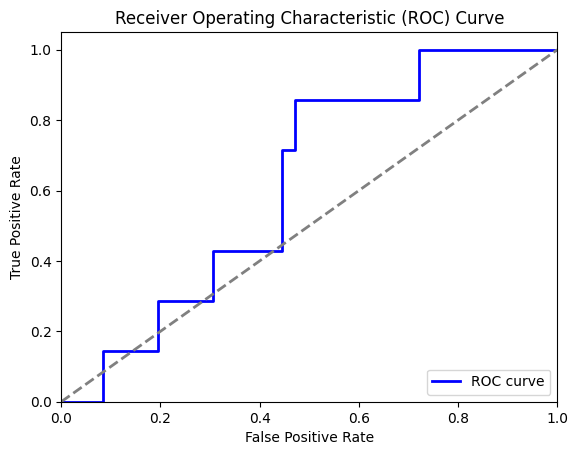

In [23]:
plot_roc_curve(list(pred_msi['Pred_Prob']),list(pred_msi['Y_True']))

In [24]:
##############################################################################################################################
# TMA
##############################################################################################################################
tma_loader = DataLoader(dataset=tma_data, batch_size=1, shuffle=False)
y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict2(model, tma_loader, device, conf, 'TMA')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    if i not in [1,5,6]:
        pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], tma_ids, ALL_LABELS[i], THRES = 0.5)
        pred_df_list.append(pred_df)
        perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)
all_perd_df.to_csv(outdir4 + "/TMA_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 +  "/TMA_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC  Recall  Specificity   ACC  Precision    PR_AUC    F1  \
SAMPLE_LEVEL  0.49    0.00          1.0  0.39       0.00  0.584782  0.00   
SAMPLE_LEVEL  0.49    1.00          0.0  0.34       0.34  0.397571  0.50   
SAMPLE_LEVEL  0.47    1.00          0.0  0.30       0.30  0.367058  0.46   
SAMPLE_LEVEL  0.52    0.01          1.0  0.50       1.00  0.534246  0.02   

                F2    F3 OUTCOME  
SAMPLE_LEVEL  0.00  0.00      AR  
SAMPLE_LEVEL  0.72  0.83    PTEN  
SAMPLE_LEVEL  0.68  0.81     RB1  
SAMPLE_LEVEL  0.01  0.01    TP53  
0.49


In [25]:
##############################################################################################################################
# TCGA
##############################################################################################################################
tcga_loader = DataLoader(dataset=tcga_data, batch_size=1, shuffle=False)
y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict2(model, tcga_loader, device, conf, 'TCGA')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    if i != 5 :
        pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], tcga_ids, ALL_LABELS[i], THRES = 0.5)
        pred_df_list.append(pred_df)
        perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)
all_perd_df.to_csv(outdir4  + "/TCGA_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5  + "/TCGA_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC  Recall  Specificity   ACC  Precision    PR_AUC    F1  \
SAMPLE_LEVEL  0.60     0.0          1.0  1.00       0.00  0.008191  0.00   
SAMPLE_LEVEL  0.57     1.0          0.0  0.08       0.08  0.206909  0.14   
SAMPLE_LEVEL  0.52     1.0          0.0  0.03       0.03  0.035497  0.06   
SAMPLE_LEVEL  0.33     1.0          0.0  0.01       0.01  0.006427  0.01   
SAMPLE_LEVEL  0.55     0.0          1.0  0.88       0.00  0.134637  0.00   
SAMPLE_LEVEL  0.22     1.0          0.0  0.01       0.01  0.007588  0.02   

                F2    F3                                           OUTCOME  
SAMPLE_LEVEL  0.00  0.00                                                AR  
SAMPLE_LEVEL  0.29  0.45  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL  0.13  0.23                                              PTEN  
SAMPLE_LEVEL  0.03  0.06                                               RB1  
SAMPLE_LEVEL  0.00  0.00                                              TP53  
SAMPL